# Regressor de fluxo

A principal ideia deste regressor é:

* Encontrar os fluxos baseados nas features como populacao, distancia da ligacao, REGIC.

* Verificar quais features possuem mais influência no regressor

* Testar diferentes modelos

In [1]:
import pandas as pd

In [70]:
#Dados arranjos/mun
df_cidades = pd.read_csv("../data/integrado/arr_mun.csv")

#Dataframe com os rotulos
df_rodoviario = pd.read_csv("../data/calculado/arr_calculo_qtd_fluxo.csv")

#Dataframe com as features
#Dados das ligacoes rodoviarias e hidroviaria IBGE 2016
df_li_trans = pd.read_csv('../data/fluxo_transporte/lig_rodo_hidro.csv', sep=",")
df_li_trans = pd.DataFrame(df_li_trans[['CODMUNDV_A', 'CODMUNDV_B','VAR03','VAR04','VAR06']])
df_li_trans.rename(columns={"ID": "id", "CODMUNDV_A": "cod_mun_a", "CODMUNDV_B": "cod_mun_b",'VAR03':"custo_min",'VAR04':"tempo_min", "VAR06": "freq_saida"}, inplace=True)

#Dados do REGIC 2018
#Integrado
df_regic = pd.read_csv('../data/integrado/cidades_regic.csv')
#Bruto
df_regic_lig = pd.read_excel(open('../data/regic/REGIC2018_Ligacoes_entre_Cidades.xlsx', 'rb'), sheet_name='REGIC2018_Ligacoes_entre_Cidade', 
                               dtype = {'cod_ori': int, 'cod_dest': int})
df_regic_lig.rename(columns={"cod_ori":"cod_origem", "cod_dest":"cod_destino"}, inplace=True)                            

In [204]:
df_li_trans_2 = pd.DataFrame(df_li_trans)
df_li_trans_2.rename(columns={"cod_mun_a":"cod_mun_b", "cod_mun_b":"cod_mun_a"}, inplace=True)

df_lig = pd.concat([df_li_trans_2,df_li_trans])
df_lig.rename(columns={"cod_mun_a":"cod_origem", "cod_mun_b":"cod_destino"}, inplace=True)

In [222]:
df_regic_dest = pd.DataFrame(df_regic.add_suffix('_dest'))
df_regic_ori = pd.DataFrame(df_regic.add_suffix('_ori'))

df_regic_merge = df_lig.merge(df_regic_dest, 
                how='inner', 
                left_on=["cod_destino"], 
                right_on=["cod_mun_dest"])

df_regic_merge = df_regic_merge.merge(df_regic_ori, 
                how='inner', 
                left_on=["cod_origem"], 
                right_on=["cod_mun_ori"])


In [223]:
df_features =  df_rodoviario.merge(df_regic_merge, 
                how='inner', 
                left_on=["cod_destino", "cod_origem"], 
                right_on=["cod_destino", "cod_origem"])

In [224]:
df_label = df_features[["passageiros_rodov"]]
df_features = df_regic_merge[[
        'custo_min', 'tempo_min', 'freq_saida',
        'pib_dest', 'PIB_agro_dest', 'PIB_ind_dest',
        'PIB_serv_dest', 'PIB_pub_dest', 'hierarquia_dest',
        'CGT_dest', 'CI_dest', 'CGP_dest',
        'indice_atracao_dest', 'ia_vestuario_dest', 'ia_moveis_dest',
        'ia_saude_bm_dest', 'ia_saude_a_dest', 'ia_ensino_sup_dest',
        'ia_cultura_dest', 'ia_esporte_dest', 'ia_aeroporto_dest',
        'ia_jornal_dest', 'ia_transporte_dest', 'num_leitos_dest',
        'pib_ori', 'PIB_agro_ori', 'PIB_ind_ori', 'PIB_serv_ori',
        'PIB_pub_ori', 'hierarquia_ori', 'CGT_ori',
        'CI_ori', 'CGP_ori', 'indice_atracao_ori', 'ia_vestuario_ori',
        'ia_moveis_ori', 'ia_saude_bm_ori', 'ia_saude_a_ori',
        'ia_ensino_sup_ori', 'ia_cultura_ori', 'ia_esporte_ori',
        'ia_aeroporto_ori', 'ia_jornal_ori', 'ia_transporte_ori',
        'num_leitos_ori'
       ]]

In [155]:
#Utilizando ligacoes do regic (vai no sentido de piramide)
# df_merge = df_rodoviario.merge(df_lig, 
#                 how='inner', 
#                 left_on=["cod_destino", "cod_origem"], 
#                 right_on=["cod_destino", "cod_origem"])

# df_features_1 = df_merge[["custo_min", "tempo_min", "freq_saida"]]
# df_label_1 = df_merge[["passageiros_rodov"]]

# df_merge = df_merge.merge(df_regic_lig, 
#                 how='inner', 
#                 left_on=["cod_destino", "cod_origem"], 
#                 right_on=["cod_destino", "cod_origem"])

# df_features_2 = df_merge[["custo_min", "tempo_min", "freq_saida", "dist_km","nivel_ori","nivel_dest",
# "quest", "quest_1","quest_2","quest_3","quest_4","quest_5","quest_6","quest_7","quest_8","quest_9","quest_10"]]
# df_label_2 = df_merge[["passageiros_rodov"]]

In [225]:
#Transformando variáveis categóricas em numéricas
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# # df_features_2["quest"] = le.fit_transform(df_features_2["quest"])
# df_features_2["nivel_ori"] = le.fit_transform(df_features_2["nivel_ori"])
# df_features_2["nivel_dest"] = le.fit_transform(df_features_2["nivel_dest"])
df_features["hierarquia_ori"] = le.fit_transform(df_features["hierarquia_ori"])
df_features["hierarquia_dest"] = le.fit_transform(df_features["hierarquia_dest"])


/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_23022/1773933322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["hierarquia_ori"] = le.fit_transform(df_features["hierarquia_ori"])
/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_23022/1773933322.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["hierarquia_dest"] = le.fit_transform(df_features["hierarquia_dest"])


In [234]:
df_features = df_features.fillna(0)

In [236]:
X = df_features_2.to_numpy()
y = df_label_2[["passageiros_rodov"]].values.ravel()

In [237]:
#Perform Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

## Classificadores


In [238]:
from time import time

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [240]:
#Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_sc, y,random_state=1, test_size=0.2)

In [241]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [242]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.007s
	Prediction time: 0.022s
	Explained variance: 0.6386792829134997
	Mean absolute error: 2064.077272727273
	R2 score: 0.6369852651093451

GradientBoostingRegressor()
	Training time: 0.502s
	Prediction time: 0.143s
	Explained variance: 0.8419116001805114
	Mean absolute error: 2214.8782926034005
	R2 score: 0.8418368753532945

KNeighborsRegressor()
	Training time: 0.001s
	Prediction time: 0.292s
	Explained variance: 0.6386792829134997
	Mean absolute error: 2064.077272727273
	R2 score: 0.6369852651093451

ExtraTreesRegressor()
	Training time: 1.528s
	Prediction time: 0.019s
	Explained variance: 0.9882181109363881
	Mean absolute error: 291.42262626262624
	R2 score: 0.9877551693952421

RandomForestRegressor()
	Training time: 1.121s
	Prediction time: 0.019s
	Explained variance: 0.7920354937010422
	Mean absolute error: 1789.338813131313
	R2 score: 0.7893033702338069

DecisionTreeRegressor()
	Training time: 0.010s
	Prediction time: 0.000s
	Explained va

### Gradient Regressor

In [244]:
GBR = GradientBoostingRegressor()

parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

r_search = RandomizedSearchCV(estimator=GBR, n_iter = 100, param_distributions = parameters, cv = 3, n_jobs=-1,verbose=3)
r_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3] END learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.2;, score=0.806 total time=   2.7s
[CV 1/3] END learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.2;, score=0.616 total time=   2.7s
[CV 3/3] END learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.2;, score=0.610 total time=   2.8s
[CV 1/3] END learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.9;, score=0.229 total time=   8.6s
[CV 3/3] END learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.9;, score=0.933 total time=   8.8s
[CV 2/3] END learning_rate=0.04, max_depth=10, n_estimators=500, subsample=0.9;, score=0.852 total time=   9.0s
[CV 1/3] END learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.9;, score=0.295 total time=  13.8s
[CV 2/3] END learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.9;, score=0.865 total time=  12.6s
[CV 3/3] END learning_rate=0.03, max_depth=4

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04],
                                        'max_depth': [4, 6, 8, 10],
                                        'n_estimators': [100, 500, 1000, 1500],
                                        'subsample': [0.9, 0.5, 0.2, 0.1]},
                   verbose=3)

In [245]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",r_search.best_estimator_)
print("\n The best score across ALL searched params:\n",r_search.best_score_)
print("\n The best parameters across ALL searched params:\n",r_search.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1500,
                          subsample=0.5)

 The best score across ALL searched params:
 0.8272715351953311

 The best parameters across ALL searched params:
 {'subsample': 0.5, 'n_estimators': 1500, 'max_depth': 10, 'learning_rate': 0.01}


In [246]:
r_search.score(X_test, y_test)

0.9909909212910439

### RandomForest Regressor

In [248]:
RFR = RandomForestRegressor()

parameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

r_search_RF = RandomizedSearchCV(estimator=RFR, param_distributions = parameters, n_iter = 100,cv = 3, n_jobs=-1,verbose=3)
r_search_RF.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.531 total time=   0.9s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.517 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.427 total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=0.403 total time=   3.1s
[CV 1/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.398 total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=0.352 total time=   3.3s
[CV 3/3

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=3)

In [249]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",r_search_RF.best_estimator_)
print("\n The best score across ALL searched params:\n",r_search_RF.best_score_)
print("\n The best parameters across ALL searched params:\n",r_search_RF.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)

 The best score across ALL searched params:
 0.8808278922592212

 The best parameters across ALL searched params:
 {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [250]:
r_search_RF.score(X_test, y_test)

0.9713645474237543

In [256]:
p = {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
rf = RandomForestRegressor(**p)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)

In [264]:
res = rf.predict(X_test)
df_res = pd.DataFrame()
df_res['prediction'] = res
df_res['label'] = y_test
rf.feature_importances_

array([0.09101515, 0.10834727, 0.27624698, 0.12252739, 0.23216648,
       0.13208174, 0.01713245, 0.00080627, 0.00072508, 0.00081299,
       0.00205981, 0.00136028, 0.00120667, 0.00214104, 0.00262165,
       0.00209866, 0.00665009])

Text(0.5, 0, 'Random Forest Feature Importance')

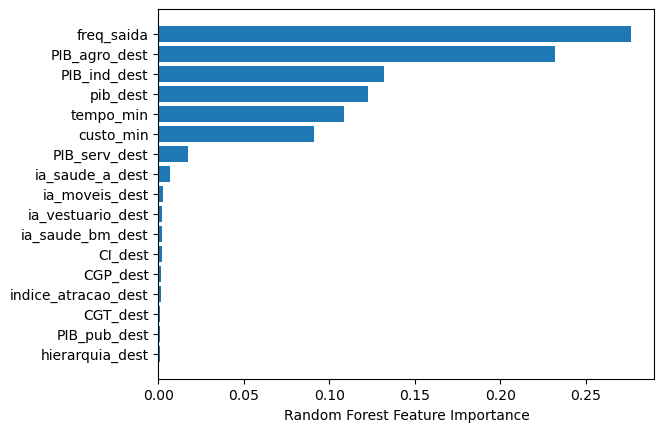

In [268]:
from matplotlib import pyplot as plt
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df_features.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### ExtraTrees Regressor

In [269]:
ETR = ExtraTreesRegressor()
parameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

r_search_ET = RandomizedSearchCV(estimator=RFR, param_distributions = parameters, n_iter = 100,cv = 3, n_jobs=-1,verbose=3)
r_search_ET.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.535 total time=   7.6s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2000;, score=0.625 total time=  10.9s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2000;, score=0.613 total time=  11.0s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2000;, score=0.517 total time=  11.2s
[CV 2/3] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.763 total time=   7.0s
[CV 1/3] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.833 total time=   5.7s
[C

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800, 1000, 1200, 1400,
                                                         1600, 1800, 2000]},
                   verbose=3)

In [270]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",r_search_ET.best_estimator_)
print("\n The best score across ALL searched params:\n",r_search_ET.best_score_)
print("\n The best parameters across ALL searched params:\n",r_search_ET.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap=False, max_depth=90, max_features='log2',
                      n_estimators=1000)

 The best score across ALL searched params:
 0.8812194088964063

 The best parameters across ALL searched params:
 {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 90, 'bootstrap': False}


In [271]:
r_search_ET.score(X_test, y_test)

0.9876511964851883

### DesicionTree Regressor

In [272]:
DTR = DecisionTreeRegressor()
parameters = {
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]}

r_search_DT = RandomizedSearchCV(estimator=DTR, param_distributions = parameters, n_iter = 100,cv = 3, n_jobs=-1,verbose=3)
r_search_DT.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.502 total time=   0.0s
[CV 2/3] END criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.386 total time=   0.0s
[CV 3/3] END criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5;, score=0.279 total time=   0.0s
[CV 1/3] END criterion=squared_error, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10;, score=0.316 total time=   0.0s
[CV 2/3] END criterion=squared_error, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10;, score=0.419 total time=   0.0s
[CV 3/3] END criterion=squared_error, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10;, score=0.047 total time=   0.0s
[CV 3/3] END criterion=absolute_error, max_depth=60, max_features=sqrt, m

RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   verbose=3)

In [273]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",r_search_DT.best_estimator_)
print("\n The best score across ALL searched params:\n",r_search_DT.best_score_)
print("\n The best parameters across ALL searched params:\n",r_search_DT.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt')

 The best score across ALL searched params:
 0.8558706082900853

 The best parameters across ALL searched params:
 {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'absolute_error'}


In [274]:
r_search_DT.score(X_test, y_test)

0.9959154118847119

## Utilizando o melhor modelo

In [ ]:
best_model = None

y_pred = grid_search.predict(X_test)

